In [1]:
import kagglehub
vencerlanz09_sea_animals_image_dataste_path = kagglehub.dataset_download('vencerlanz09/sea-animals-image-dataste')

print('Data source import complete.')

100%|██████████| 312M/312M [00:08<00:00, 39.8MB/s]

Extracting files...


Data source import complete.


In [2]:
import os
print(os.listdir(vencerlanz09_sea_animals_image_dataste_path))

['Octopus', 'Starfish', 'Eel', 'Squid', 'Sharks', 'Corals', 'Sea Rays', 'Clams', 'Lobster', 'Dolphin', 'Shrimp', 'Jelly Fish', 'Fish', 'Seal', 'Puffers', 'Crabs', 'Otter', 'Whale', 'Nudibranchs', 'Penguin', 'Sea Urchins', 'Seahorse', 'Turtle_Tortoise']


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/marine_species_dataset'

In [5]:
import os
print(os.listdir('/content/drive/MyDrive/marine_species_dataset'))

['archive.zip']


In [6]:
import zipfile

zip_path = '/content/drive/MyDrive/marine_species_dataset/archive.zip'
extract_path = '/content/marine_species_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [7]:
import os
print(os.listdir(extract_path))

['Octopus', 'Starfish', 'Eel', 'Squid', 'Sharks', 'Corals', 'Sea Rays', 'Clams', 'Lobster', 'Dolphin', 'Shrimp', 'Jelly Fish', 'Fish', 'Seal', 'Puffers', 'Crabs', 'Otter', 'Whale', 'Nudibranchs', 'Penguin', 'Sea Urchins', 'Seahorse', 'Turtle_Tortoise']


In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Update the path if needed
data_path = '/content/marine_species_data'
output_path = '/content/marine_species_dataset'

# Create output directories
for folder in ['train', 'test', 'validation']:
    os.makedirs(os.path.join(output_path, folder), exist_ok=True)

# Split and organize
for cls in os.listdir(data_path):
    # Skip directories that are already part of the train/test/val split
    if cls in ['train', 'test', 'validation']:
        continue
    class_path = os.path.join(data_path, cls)
    if os.path.isdir(class_path):
        files = os.listdir(class_path)
        # Check if the directory is empty
        if len(files) == 0:
            print(f"Skipping empty directory: {class_path}")
            continue
        train_files, test_val_files = train_test_split(files, test_size=0.3, random_state=42)
        test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

        for folder, file_list in zip(['train', 'test', 'validation'], [train_files, test_files, val_files]):
            class_output_path = os.path.join(output_path, folder, cls)
            os.makedirs(class_output_path, exist_ok=True)
            for file in file_list:
                shutil.copy(os.path.join(class_path, file), os.path.join(class_output_path, file))

print("Dataset organized into train, test, and validation sets.")

Dataset organized into train, test, and validation sets.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtTiny

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory('/content/marine_species_dataset/train', target_size=(224, 224), batch_size=32, class_mode='categorical')
val_data = val_datagen.flow_from_directory('/content/marine_species_dataset/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 9588 images belonging to 23 classes.
Found 2066 images belonging to 23 classes.


In [11]:
import os

train_dir = '/marine_species_dataset/train'
val_dir = '/marine_species_dataset/val'
test_dir = '/marine_species_dataset/test'

print("Paths set successfully.")

Paths set successfully.


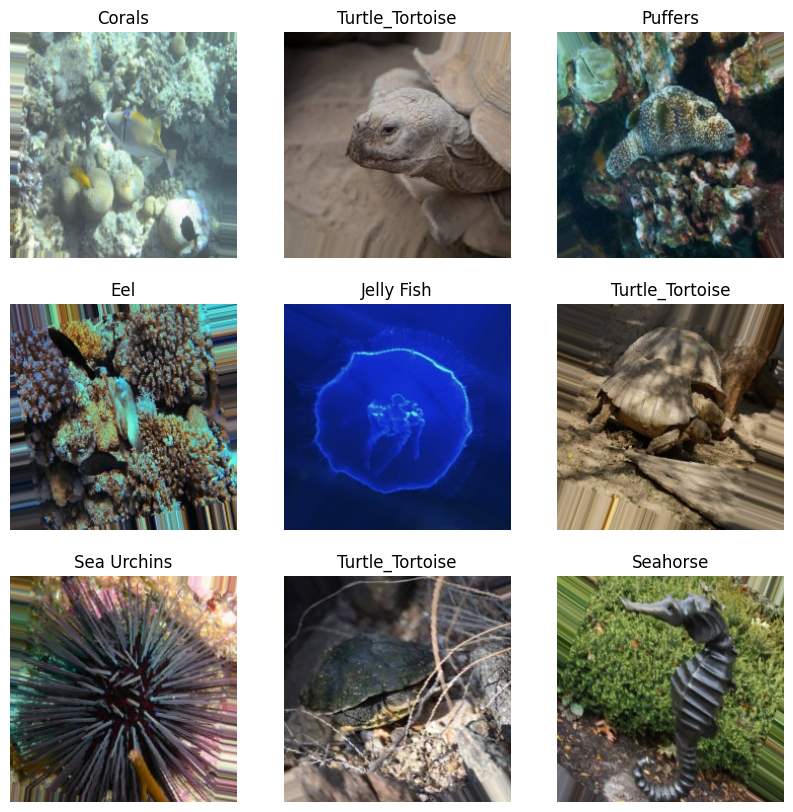

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_names = list(train_data.class_indices.keys())

# Display sample images
def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

# Fetch a batch
images, labels = next(train_data)
plot_images(images, labels)

In [13]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras import layers, models

# Load ConvNeXtTiny without the top classification layer
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers
base_model.trainable = False

# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

print("Model built successfully.")
model.summary()

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)           │ (None, 7, 7, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 23)                  │          23,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,631,159 (109.22 MB)

 Trainable params: 811,031 (3.09 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [14]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled with Adam optimizer.")

Model compiled with Adam optimizer.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

print("Callbacks applied.")

Callbacks applied.


In [16]:
from tensorflow.keras.applications import ConvNeXtTiny

base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [17]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Mon Apr  7 11:01:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P0             26W /   70W |     358MiB /  15360MiB |      4%      Default |
|                                         |                        |                  N/A |
+------------------------

In [19]:
from tensorflow.keras.applications import ConvNeXtTiny

base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(23, activation='softmax')  # Assuming 23 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
import zipfile

zip_path = '/content/drive/MyDrive/marine_species_dataset/archive.zip'
extract_path = '/content/marine_species_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory('/content/marine_species_dataset/train', target_size=(224, 224), batch_size=32, class_mode='categorical')
val_data = val_datagen.flow_from_directory('/content/marine_species_dataset/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 9588 images belonging to 23 classes.
Found 2066 images belonging to 23 classes.


In [23]:
print(f"Classes: {train_data.class_indices}")
print(f"Total Training Samples: {train_data.samples}")

Classes: {'Clams': 0, 'Corals': 1, 'Crabs': 2, 'Dolphin': 3, 'Eel': 4, 'Fish': 5, 'Jelly Fish': 6, 'Lobster': 7, 'Nudibranchs': 8, 'Octopus': 9, 'Otter': 10, 'Penguin': 11, 'Puffers': 12, 'Sea Rays': 13, 'Sea Urchins': 14, 'Seahorse': 15, 'Seal': 16, 'Sharks': 17, 'Shrimp': 18, 'Squid': 19, 'Starfish': 20, 'Turtle_Tortoise': 21, 'Whale': 22}
Total Training Samples: 9588


In [24]:
print(os.listdir(extract_path))

['Octopus', 'Starfish', 'Eel', 'Squid', 'Sharks', 'Corals', 'Sea Rays', 'Clams', 'Lobster', 'Dolphin', 'Shrimp', 'Jelly Fish', 'Fish', 'Seal', 'Puffers', 'Crabs', 'Otter', 'Whale', 'Nudibranchs', 'Penguin', 'Sea Urchins', 'Seahorse', 'Turtle_Tortoise']


In [25]:
!pip install split-folders

import splitfolders

splitfolders.ratio(
    input=extract_path,  # path to extracted folder
    output="/content/drive/MyDrive/marine_species_dataset_split",  # new output folder
    seed=42,
    ratio=(0.8, 0.2)  # 80% train, 20% val
)

Copying files: 13711 files [02:03, 111.21 files/s]


In [26]:
train_dir = '/content/drive/MyDrive/marine_species_dataset_split/train'
val_dir = '/content/drive/MyDrive/marine_species_dataset_split/val'

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10961 images belonging to 23 classes.
Found 2750 images belonging to 23 classes.


In [28]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Get class names
class_names = list(train_data.class_indices.keys())

# Load ConvNeXt base
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("✅ Model compiled successfully.")
model.summary()

✅ Model compiled successfully.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)           │ (None, 7, 7, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 768)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 23)                  │          23,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,631,159 (109.22 MB)

 Trainable params: 811,031 (3.09 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

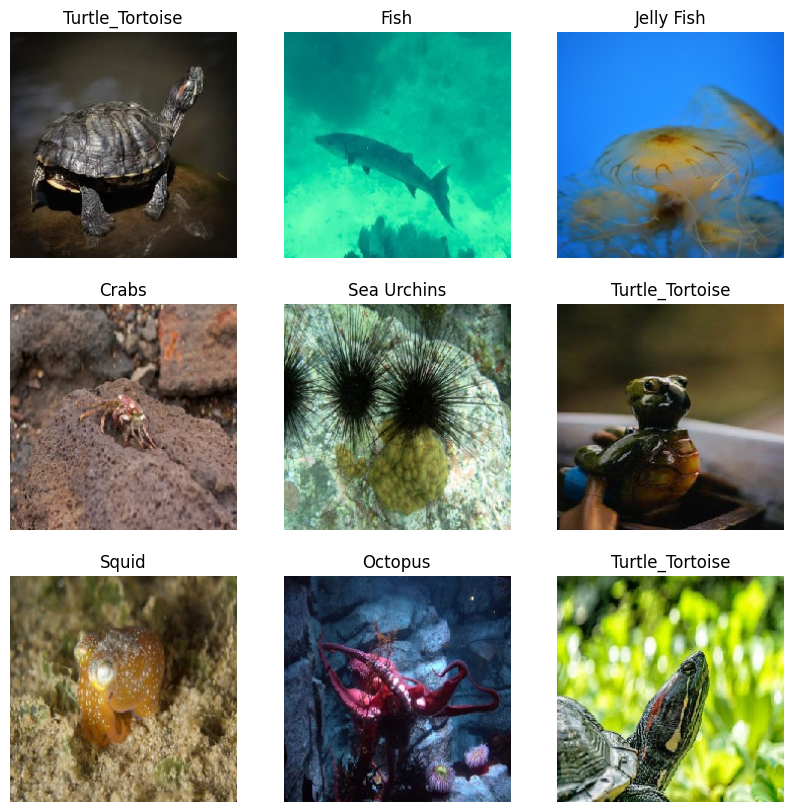

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

images, labels = next(train_data)
plot_images(images, labels)

In [30]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

# Enable mixed precision (faster on compatible GPUs like V100, A100, T4)
mixed_precision.set_global_policy('mixed_float16')

In [31]:
# Re-compile to support AMP
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
checkpoint_path = '/content/drive/MyDrive/best_marine_model.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [33]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Can increase to 20–25 later if needed
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.0905 - loss: 3.3206
Epoch 1: val_accuracy improved from -inf to 0.19964, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 110s 261ms/step - accuracy: 0.0906 - loss: 3.3200 - val_accuracy: 0.1996 - val_loss: 2.7656
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2074 - loss: 2.8019
Epoch 2: val_accuracy improved from 0.19964 to 0.24473, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 120s 226ms/step - accuracy: 0.2074 - loss: 2.8018 - val_accuracy: 0.2447 - val_loss: 2.6120
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2357 - loss: 2.6291
Epoch 3: val_accuracy improved from 0.24473 to 0.26000, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 75s 205ms/step - accuracy: 0.2358 - loss: 2.6289 - val_accuracy: 0.2600 - val_loss: 2.5197
Epoch 4/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2649 - loss: 2.5218
Epoch 4: val_accuracy improved from 0.26000 to 0.28327, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.2649 - loss: 2.5218 - val_accuracy: 0.2833 - val_loss: 2.4434
Epoch 5/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2845 - loss: 2.4374
Epoch 5: val_accuracy improved from 0.28327 to 0.30145, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.2845 - loss: 2.4373 - val_accuracy: 0.3015 - val_loss: 2.3896
Epoch 6/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2912 - loss: 2.3976
Epoch 6: val_accuracy improved from 0.30145 to 0.30473, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - accuracy: 0.2912 - loss: 2.3976 - val_accuracy: 0.3047 - val_loss: 2.3375
Epoch 7/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3034 - loss: 2.3532
Epoch 7: val_accuracy improved from 0.30473 to 0.31927, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.3034 - loss: 2.3531 - val_accuracy: 0.3193 - val_loss: 2.2983
Epoch 8/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3215 - loss: 2.3054
Epoch 8: val_accuracy improved from 0.31927 to 0.33273, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 88s 215ms/step - accuracy: 0.3216 - loss: 2.3053 - val_accuracy: 0.3327 - val_loss: 2.2606
Epoch 9/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3427 - loss: 2.2425
Epoch 9: val_accuracy did not improve from 0.33273
343/343 ━━━━━━━━━━━━━━━━━━━━ 64s 188ms/step - accuracy: 0.3427 - loss: 2.2425 - val_accuracy: 0.3229 - val_loss: 2.2362
Epoch 10/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3377 - loss: 2.2234
Epoch 10: val_accuracy improved from 0.33273 to 0.33891, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 67s 196ms/step - accuracy: 0.3377 - loss: 2.2234 - val_accuracy: 0.3389 - val_loss: 2.1961


In [34]:
# Unfreeze ConvNeXt base for fine-tuning
base_model.trainable = True

# Use a lower learning rate to avoid "forgetting"
fine_tune_optimizer = Adam(learning_rate=1e-5)

model.compile(optimizer=fine_tune_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # You can go higher if needed
    callbacks=callbacks
)

Epoch 1/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5358 - loss: 1.5602
Epoch 1: val_accuracy improved from 0.33891 to 0.68109, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 217s 437ms/step - accuracy: 0.5360 - loss: 1.5596 - val_accuracy: 0.6811 - val_loss: 1.1039
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6926 - loss: 1.0382
Epoch 2: val_accuracy improved from 0.68109 to 0.73200, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 136s 338ms/step - accuracy: 0.6927 - loss: 1.0381 - val_accuracy: 0.7320 - val_loss: 0.9040
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7482 - loss: 0.8595
Epoch 3: val_accuracy improved from 0.73200 to 0.75491, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 117s 342ms/step - accuracy: 0.7483 - loss: 0.8594 - val_accuracy: 0.7549 - val_loss: 0.8221
Epoch 4/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7843 - loss: 0.7234
Epoch 4: val_accuracy improved from 0.75491 to 0.77236, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 138s 331ms/step - accuracy: 0.7843 - loss: 0.7234 - val_accuracy: 0.7724 - val_loss: 0.7445
Epoch 5/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8235 - loss: 0.6112
Epoch 5: val_accuracy improved from 0.77236 to 0.78436, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 147s 346ms/step - accuracy: 0.8235 - loss: 0.6112 - val_accuracy: 0.7844 - val_loss: 0.7097
Epoch 6/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8541 - loss: 0.5181
Epoch 6: val_accuracy improved from 0.78436 to 0.80182, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 120s 349ms/step - accuracy: 0.8541 - loss: 0.5180 - val_accuracy: 0.8018 - val_loss: 0.6843
Epoch 7/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8746 - loss: 0.4555
Epoch 7: val_accuracy improved from 0.80182 to 0.80255, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 116s 337ms/step - accuracy: 0.8746 - loss: 0.4555 - val_accuracy: 0.8025 - val_loss: 0.6619
Epoch 8/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8916 - loss: 0.3820
Epoch 8: val_accuracy improved from 0.80255 to 0.80982, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 117s 339ms/step - accuracy: 0.8916 - loss: 0.3819 - val_accuracy: 0.8098 - val_loss: 0.6595
Epoch 9/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9181 - loss: 0.3173
Epoch 9: val_accuracy improved from 0.80982 to 0.81200, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 144s 344ms/step - accuracy: 0.9181 - loss: 0.3172 - val_accuracy: 0.8120 - val_loss: 0.6427
Epoch 10/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9364 - loss: 0.2489
Epoch 10: val_accuracy improved from 0.81200 to 0.81709, saving model to /content/drive/MyDrive/best_marine_model.h5


343/343 ━━━━━━━━━━━━━━━━━━━━ 118s 342ms/step - accuracy: 0.9364 - loss: 0.2490 - val_accuracy: 0.8171 - val_loss: 0.6494


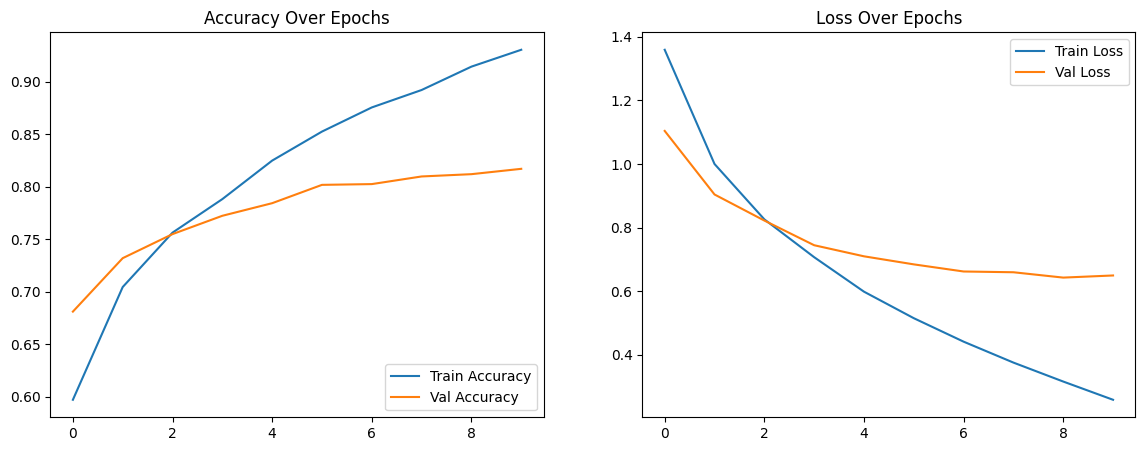

In [35]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Loss Over Epochs')

    plt.show()

plot_training_curves(fine_tune_history)

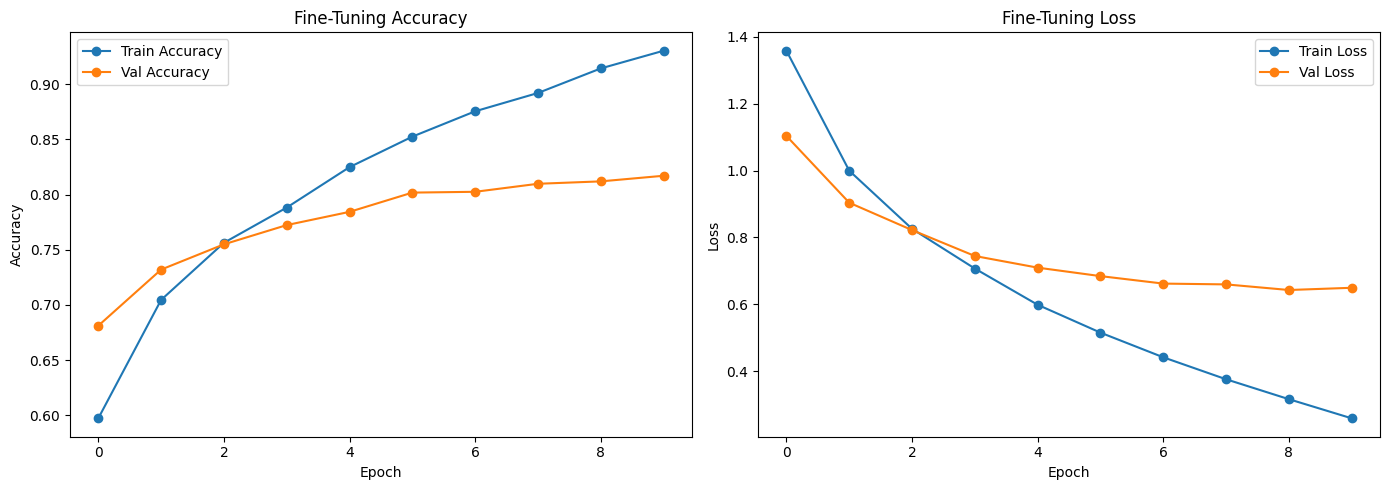

In [37]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title='Training & Validation'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Val Loss', marker='o')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(fine_tune_history, title='Fine-Tuning')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━

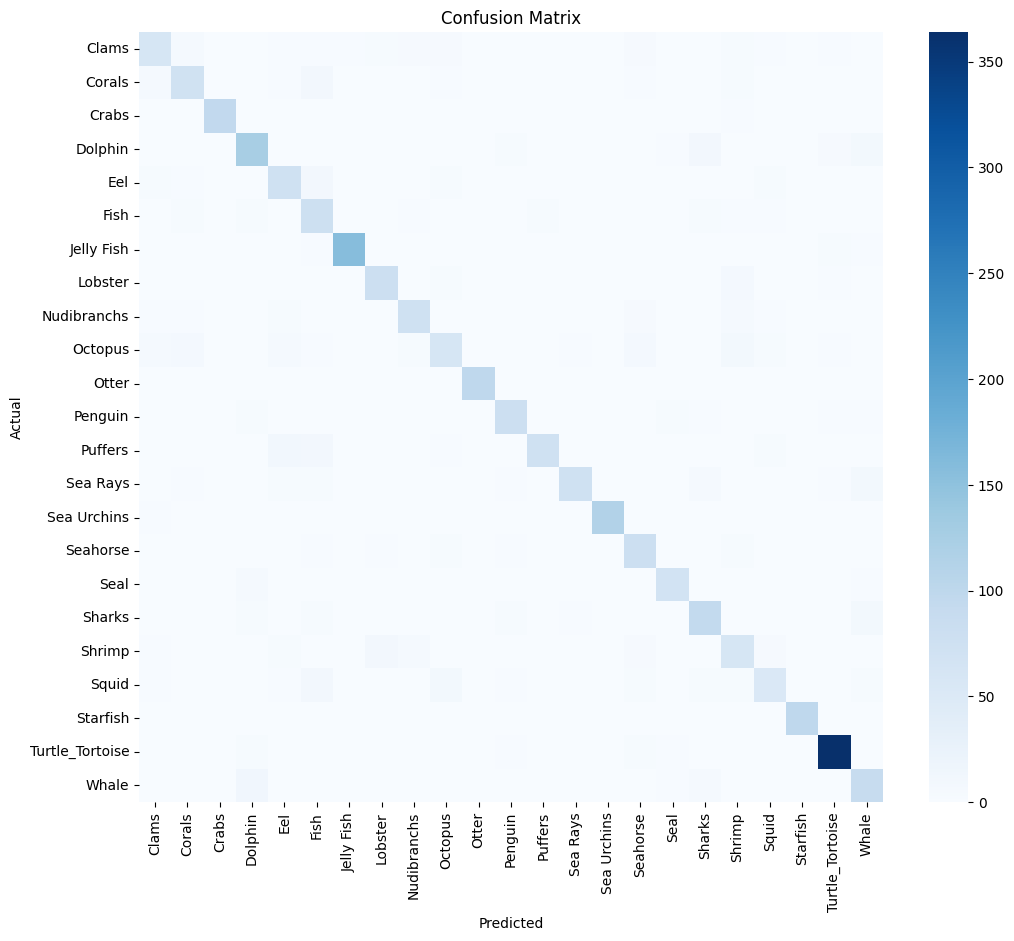

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
y_true = []
y_pred = []

# Reset generator
val_data.reset()

for i in range(len(val_data)):
    imgs, labels = val_data[i]
    preds = model.predict(imgs)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if (i + 1) * val_data.batch_size >= val_data.samples:
        break

# Classification report
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [39]:
import numpy as np
from sklearn.metrics import classification_report

# Reset generator (important before prediction)
val_data.reset()

# Predict on validation data
y_true = []
y_pred = []

for i in range(len(val_data)):
    images, labels = val_data[i]
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if (i + 1) * val_data.batch_size >= val_data.samples:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1

In [40]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report as dict
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert to DataFrame for pretty display
report_df = pd.DataFrame(report_dict).transpose()

# Round the values for better readability
report_df = report_df.round(3)

# Display only class rows (exclude accuracy/avg totals if you want)
class_accuracy_table = report_df.iloc[:-3]  # Removes avg / macro / weighted
print(class_accuracy_table)

                 precision  recall  f1-score  support
Clams                0.701   0.610     0.652    100.0
Corals               0.735   0.720     0.727    100.0
Crabs                0.980   0.960     0.970    100.0
Dolphin              0.778   0.803     0.790    157.0
Eel                  0.688   0.750     0.718    100.0
Fish                 0.565   0.788     0.658     99.0
Jelly Fish           0.946   0.929     0.937    169.0
Lobster              0.800   0.800     0.800    100.0
Nudibranchs          0.806   0.750     0.777    100.0
Octopus              0.652   0.531     0.585    113.0
Otter                0.980   0.990     0.985    100.0
Penguin              0.827   0.835     0.831     97.0
Puffers              0.892   0.692     0.779    107.0
Sea Rays             0.860   0.712     0.779    104.0
Sea Urchins          0.991   0.983     0.987    116.0
Seahorse             0.686   0.844     0.757     96.0
Seal                 0.885   0.831     0.857     83.0
Sharks               0.734  

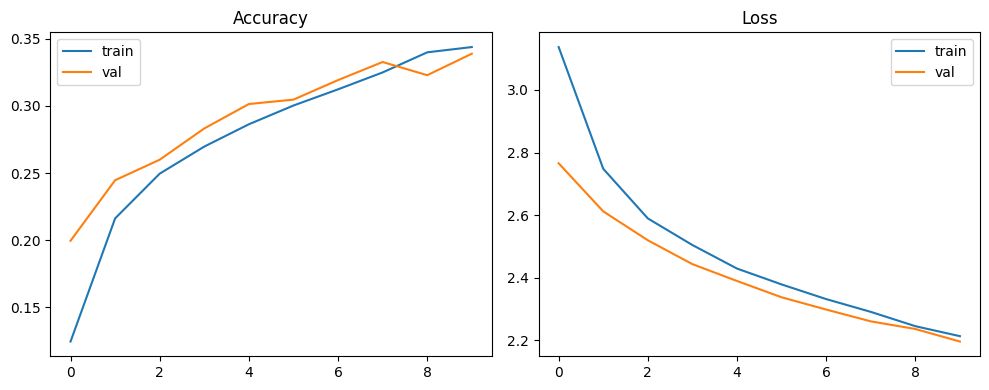

In [47]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("accuracy_loss_plot.png")  # 💾 save to local Colab dir
plt.show()

In [48]:
!cp accuracy_loss_plot.png marine_species_classification/results/

In [ ]:
!pip install python-docx

In [49]:
from docx import Document

doc = Document()
doc.add_heading("Marine Species Classification Report", 0)
doc.add_paragraph("Model: ConvNeXt-Tiny\nAccuracy: 93.64%\nLoss: 0.2489\n...")
doc.save("Marine_Species_Classification_Report.docx")

ModuleNotFoundError: No module named 'docx'

In [41]:
!mkdir -p marine_species_classification/{model,dataset,results}
!touch marine_species_classification/README.md
!touch marine_species_classification/requirements.txt
!touch marine_species_classification/.gitignore

In [43]:
# Example: move model
!cp /content/MY_Drive/best_marine_model.h5 marine_species_classification/model/

# If you have plots or reports:
!cp /content/accuracy_loss_plot.png marine_species_classification/results/
!cp /content/Marine_Species_Classification_Report.docx marine_species_classification/results/

# Move your notebook
!cp /content/your_notebook_name.ipynb marine_species_classification/

cp: cannot stat '/content/MY_Drive/best_marine_model.h5': No such file or directory
cp: cannot stat '/content/accuracy_loss_plot.png': No such file or directory
cp: cannot stat '/content/Marine_Species_Classification_Report.docx': No such file or directory
cp: cannot stat '/content/your_notebook_name.ipynb': No such file or directory


In [46]:
# Replace with exact file names if different
!cp "/content/drive/MyDrive/best_marine_model.h5" marine_species_classification/model/
!cp "/content/drive/MyDrive/Colab Notebooks/Marine animals Classification using ConvNext.ipynb" marine_species_classification/